# Guia para marcação de sequência com redes neurais em Python

Este script mostra como implementar um **Named Entity Recognition** com uma **LSTM bidirecional** em Python usando Keras. Este exemplo foi retirado do link a seguir, onde você encontrará mais exemplos e arquiteturas mais complexas.

https://www.depends-on-the-definition.com/guide-sequence-tagging-neural-networks-python/



##A tarefa: reconhecimento de entidade nomeada

*Named Entity Recognition* (NER) (também conhecido como identificação de entidade, fragmentação de entidade e extração de entidade) é uma subtarefa de extração de informações que busca localizar e classificar menções de entidades nomeadas em texto não estruturado em categorias predefinidas, como nomes de pessoas , organizações, locais, códigos médicos, expressões de tempo, quantidades, valores monetários, porcentagens, etc.

A tarefa aqui é modelada como uma tarefa de rotulagem sequencial onde cada palavra é atribuída a um rótulo que reflete a possível Entidade Nomeada que ela expressa.

O formato IOB (abreviação de dentro, fora, início) é um formato de marcação comum para definir rótulos úteis para a tarefa. Foi apresentado por Ramshaw e Marcus em seu artigo "Text Chunking using Transformation-Based Learning", 1995.
O prefixo `B-` antes de uma tag indica que a tag é o início de um pedaço, e um prefixo `I-` antes de uma tag indica que a tag está dentro de um pedaço. A tag `B-` é usada somente quando uma tag é seguida por uma tag do mesmo tipo sem tokens O entre elas. Uma tag `O` indica que um token não pertence a nenhum pedaço.

Um exemplo com formato IOB:

```
B-GPE da UE
rejeita O
Alemão B-MISC
ligue para O
desde O
o Ó
B-GPE Unido
Estados I-GPE
```




#Um modelo neural recorrente para a tarefa NERC

A ideia é usar dois LSTMs, um lendo cada palavra de uma frase do começo ao fim e outro lendo a mesma mas do fim ao começo, produzindo para cada palavra, uma representação vetorial feita tanto do LSTM desdobrado (ou seja, para frente e para trás) leia até essa palavra. A intuição é que o vetor para cada palavra levará em conta as palavras lidas/vistas antes, em ambas as direções.

Dadas as duas saídas fornecidas para cada palavra (em cada direção), um único vetor é obtido via concatenação e um classificador linear é aplicado para atribuir cada trabalho a uma tag que reflete a tarefa NER final.


Primeiro, importamos os módulos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Model
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import Image
from keras.utils import plot_model



print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

if K.backend() == "tensorflow":
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())

Using Keras version: 2.14.0 backend: tensorflow
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1357451640563839752
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40161050624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6210268716095158444
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


<ipython-input-1-bada15044ded>:23: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert(LV(__version__) >= LV("2.0.0"))


##Carregando os dados##

A dataset é oriunda deste projeto https://github.com/DigantaD/NER.git

O arquivo utilizado é https://github.com/DigantaD/NER/blob/master/ner_dataset.csv

Observe que apenas um conjunto de dados é carregado e será dividido em um trem e subconjuntos de teste durante a fase de treinamento da rede neural.

In [2]:
! git clone https://github.com/DigantaD/NER.git
data = pd.read_csv("./NER/ner_dataset.csv", encoding="latin1")

# Fill the first column of the CSV file which is empty
data = data.fillna(method="ffill")

#Print the last 100 rows of the input fil
data.tail(10)

Cloning into 'NER'...
remote: Enumerating objects: 6, done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 6
Receiving objects: 100% (6/6), 3.10 MiB | 5.59 MiB/s, done.


,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [3]:
#Get the complete list of words
words = list(set(data["Word"].values))
words.append("ENDPAD")
#Count the size of the dictionary, after adding a special token ENDPAD that
#will be used to pad sentences
n_words = len(words);
print("Number of different words:\t" + str(n_words))

#Count the tags
tags = list(set(data["Tag"].values))
n_tags = len(tags);
print("Number of different tags:\t" + str(n_tags))
print("List of different tags:\t" + str(set(tags)))

Number of different words:	35179
Number of different tags:	17
List of different tags:	{'I-org', 'I-geo', 'B-eve', 'B-org', 'I-gpe', 'B-per', 'B-art', 'B-nat', 'I-art', 'I-nat', 'B-geo', 'B-tim', 'B-gpe', 'O', 'I-tim', 'I-eve', 'I-per'}


Portanto temos 47.959 sentenças contendo 35.179 palavras diferentes (considerando também a tag específica ENDPAD) com 17 tags diferentes.

Usamos a classe SentenceGetter para recuperar frases com seus rótulos.

In [4]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

As frases são carregadas do arquivo de input

The first sentence is[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


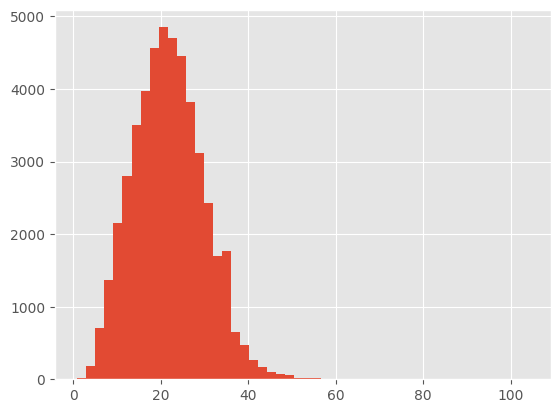

In [5]:
#Split sentences
getter = SentenceGetter(data)
#Get the first sentence
sent = getter.get_next()
print("The first sentence is" + str(sent))

#Load all sentences
sentences = getter.sentences

#Print the length distribution
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

## Convertendo frases e tags em vetores

As sentenças são convertidas em sequências de comprimento igual `max_len` (aqui 50). Um **padding** é aplicado a frases mais curtas.

Cada palavra no dicionário de entrada é atribuída a um número que será posteriormente emparelhado com um vetor (inicializado aleatoriamente).



In [6]:
#Maximum length of the input sequences
max_len = 50

#Word and tags in the input word and tag dictionaries are numbered
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
print("The word \"Iranian\" is assigned to  " + str(word2idx["Iranian"]))
print("The tag \"B-gpe\" is assigned to " + str(tag2idx["B-gpe"]))

#Each sentence is converted into sequences of numbers, given the above dictionaries
X = [[word2idx[w[0]] for w in s] for s in sentences]

print("\nBefor PADDING")
print("Original Sentence 1:\t" + str(sentences[1]))
print("Numerical Representation 1:\t" + str(X[1]))
print("Length of Sentence 1:" + str(len(X[1])))

#APPLY PADDING
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)


print("The special word ENDPAD (used for padding) is assigned to:\t" + str(word2idx["ENDPAD"]))

print("\nAfter PADDING")
print("Numerical Representation 1:\t" + str(X[1]))
print("Length of Sentence 1:" + str(len(X[1])))


The word "Iranian" is assigned to  31310
The tag "B-gpe" is assigned to 12

Befor PADDING
Original Sentence 1:	[('Iranian', 'JJ', 'B-gpe'), ('officials', 'NNS', 'O'), ('say', 'VBP', 'O'), ('they', 'PRP', 'O'), ('expect', 'VBP', 'O'), ('to', 'TO', 'O'), ('get', 'VB', 'O'), ('access', 'NN', 'O'), ('to', 'TO', 'O'), ('sealed', 'JJ', 'O'), ('sensitive', 'JJ', 'O'), ('parts', 'NNS', 'O'), ('of', 'IN', 'O'), ('the', 'DT', 'O'), ('plant', 'NN', 'O'), ('Wednesday', 'NNP', 'B-tim'), (',', ',', 'O'), ('after', 'IN', 'O'), ('an', 'DT', 'O'), ('IAEA', 'NNP', 'B-org'), ('surveillance', 'NN', 'O'), ('system', 'NN', 'O'), ('begins', 'VBZ', 'O'), ('functioning', 'VBG', 'O'), ('.', '.', 'O')]
Numerical Representation 1:	[31310, 28158, 31603, 32763, 653, 21175, 19954, 24509, 21175, 14509, 2104, 13727, 4851, 34616, 21018, 12829, 29865, 13051, 35005, 32474, 406, 16222, 7311, 4290, 26634]
Length of Sentence 1:25
The special word ENDPAD (used for padding) is assigned to:	35178

After PADDING
Numerical Repre

Os rótulos de saída também são convertidos em sequências, com comprimento máximo igual a max_len (aqui 50). Um preenchimento é aplicado a frases mais curtas, atribuindo aos elementos preenchidos o rótulo `O`.

In [7]:
# Converting output labels into number and padding
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

print("\nAfter PADDING")
print("Output labels of 1:\t" + str(y[1]))

#Converting to categorial elements
y = [to_categorical(i, num_classes=n_tags) for i in y]

print("Categorial Output labels for the first 10 tokens:\t" + str(y[1][0:10]))



After PADDING
Output labels of 1:	[12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 11 13 13 13  3 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13]
Categorial Output labels for the first 10 tokens:	[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


Dividindo a dataset

In [8]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

print("Size of the train dataset:\t" + str(len(X_tr))+ " sequences.")
print("Size of the test dataset:\t" + str(len(X_te))+ " sequences.")


Size of the train dataset:	43163 sequences.
Size of the test dataset:	4796 sequences.


## Definindo a RNN

KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 17)            3417      
 ributed)                                                        
                                                                 
Total params: 1883167 (7.18 MB)
Trainable params: 1883167 (7.

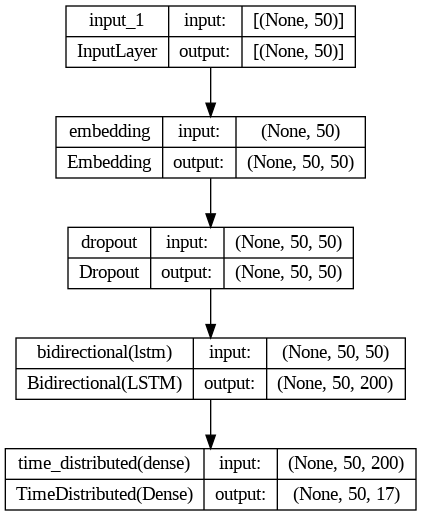

In [9]:
input = Input(shape=(max_len,))

print(input)

# O input (agora sequências de números) são mapeadas em vetores de dimensionalidade 50
# https://keras.io/layers/embeddings/
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)

# Aplicando Dropout
# https://keras.io/layers/core/#dropout
model = Dropout(0.1)(model)

# Definindo uma LSTM
#model = LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)(model)

# Definida uma LSTM bidirecional. Observe que a saída obtida de cada palavra é
# fornecido apenas especificando return_sequences=True
# https://keras.io/layers/wrappers/
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)

# Uma camada densa é definida para reduzir o espaço à mesma dimensionalidade da saída
# Um softmax é aplicado
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

# O modelo é compilado
model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

#Imprimindo o modelo
model.summary()

#Visualizando em uma imagem
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')


*Vamos* treinar o modelo! *Obs: Estimativa que deve levar ~30-45min na GPU gratuita do Colab.*

In [10]:
batch_size = 32
epochs = 10

history = model.fit(X_tr, np.array(y_tr), batch_size = batch_size, epochs = epochs, validation_split=0.1, verbose=1)

Epoch 1/10
1214/1214 [==============================] - 335s 266ms/step - loss: 0.1705 - accuracy: 0.9612 - val_loss: 0.0637 - val_accuracy: 0.9812
Epoch 2/10
1214/1214 [==============================] - 308s 253ms/step - loss: 0.0503 - accuracy: 0.9851 - val_loss: 0.0493 - val_accuracy: 0.9848
Epoch 3/10
1214/1214 [==============================] - 304s 251ms/step - loss: 0.0369 - accuracy: 0.9886 - val_loss: 0.0469 - val_accuracy: 0.9855
Epoch 4/10
1214/1214 [==============================] - 307s 253ms/step - loss: 0.0303 - accuracy: 0.9904 - val_loss: 0.0465 - val_accuracy: 0.9857
Epoch 5/10
1214/1214 [==============================] - 305s 252ms/step - loss: 0.0261 - accuracy: 0.9916 - val_loss: 0.0476 - val_accuracy: 0.9859
Epoch 6/10
1214/1214 [==============================] - 304s 251ms/step - loss: 0.0229 - accuracy: 0.9925 - val_loss: 0.0503 - val_accuracy: 0.9856
Epoch 7/10
1214/1214 [==============================] - 306s 252ms/step - loss: 0.0205 - accuracy: 0.9933 - val_

Resultados na Train/Validation datasets

---



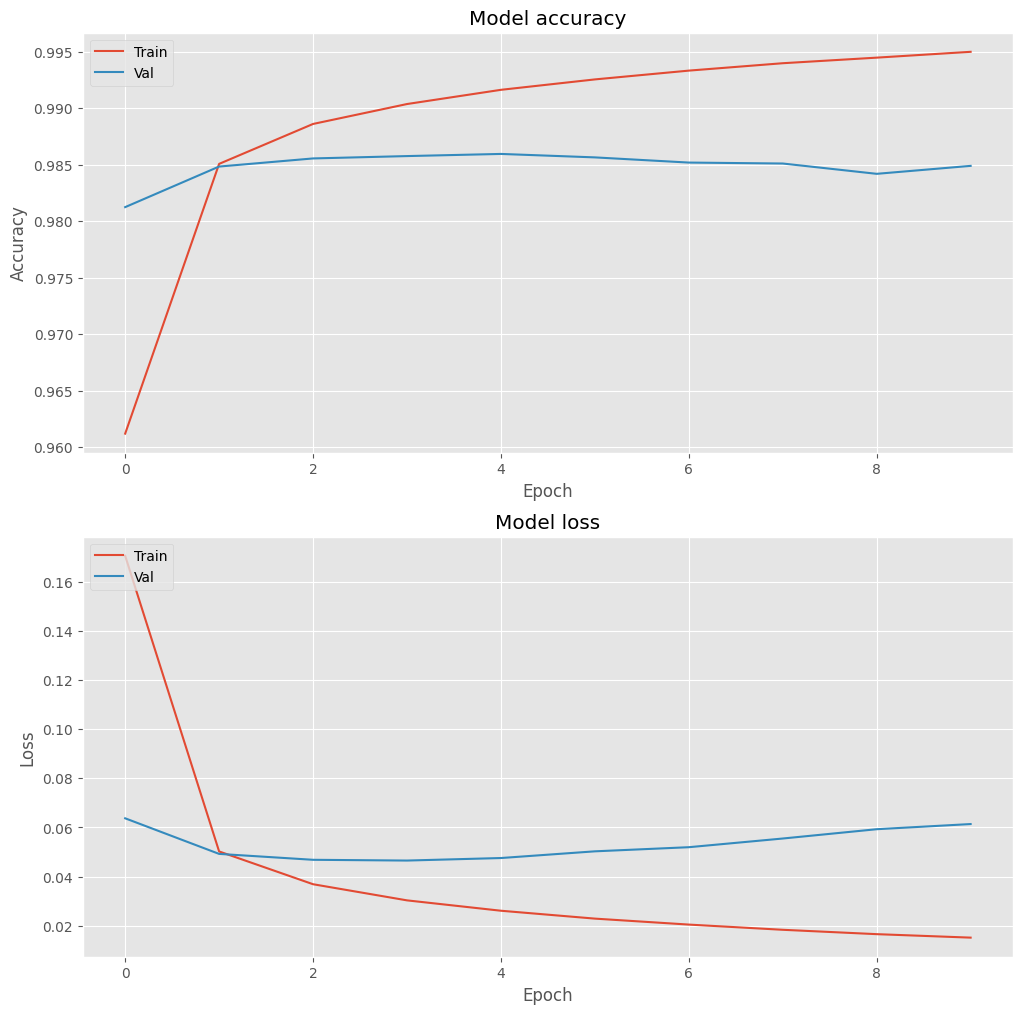

In [11]:
# Converta o dicionário history.history em um DataFrame do pandas
hist = pd.DataFrame(history.history)

# Crie uma figura com subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plotar training & validation accuracy
axs[0].plot(hist["accuracy"])
axs[0].plot(hist["val_accuracy"])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Val'], loc='upper left')

# Plotar training & validation loss
axs[1].plot(hist["loss"])
axs[1].plot(hist["val_loss"])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Val'], loc='upper left')

# Mostrar o plot
plt.show()


Vamos ver os resultados nos conjuntos de dados de teste (os últimos 10% das sentenças do conjunto de dados original)

In [12]:
%%time
scores = model.evaluate(X_te, np.array(y_te), verbose=2, batch_size=100)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

48/48 - 1s - loss: 0.0621 - accuracy: 0.9849 - 1s/epoch - 27ms/step
accuracy: 98.49%
CPU times: user 1.43 s, sys: 37 ms, total: 1.47 s
Wall time: 1.39 s


Podemos ver agora uma frase rotulada

In [13]:
i = 2318
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))

1/1 [==============================] - 0s 446ms/step
Word            (True ): Pred
Hours          : O
later          : O
,              : O
in             : O
western        : B-geo
Gujarat        : I-geo
state          : O
,              : O
a              : O
truck          : O
carrying       : O
sacks          : O
of             : O
salt           : O
and            : O
19             : O
people         : O
overturned     : O
and            : O
crashed        : O
into           : O
a              : O
flooded        : O
ditch          : O
.              : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         :

## Exercício

Meça a qualidade do NER usando precision, recall e F1 score sobre entidades (em vez de accuracy sobre tokens)

In [14]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

print("Size of the train dataset:\t" + str(len(X_tr))+ " sequences.")
print("Size of the test dataset:\t" + str(len(X_te))+ " sequences.")

Size of the train dataset:	43163 sequences.
Size of the test dataset:	4796 sequences.


In [15]:
import tensorflow as tf

def f1_score(y_true, y_pred):
    """
    Compute F1 Score using TensorFlow operations.
    """
    # Calculate precision and recall
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

    # Calculate F1 score
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    return f1_val


KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 50)            1758950   
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 50, 200)           120800    
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 50, 17)            3417      
 stributed)                                    

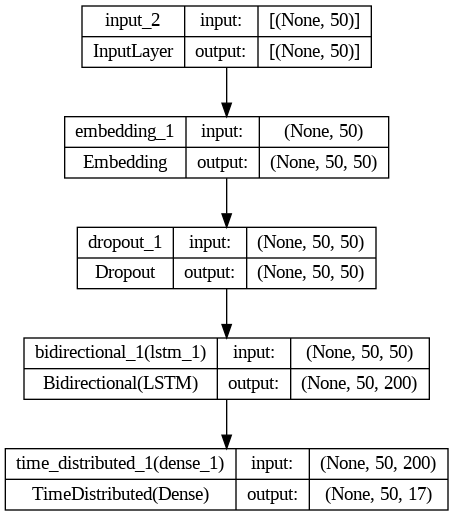

In [16]:
input = Input(shape=(max_len,))

print(input)

# O input (agora sequências de números) são mapeadas em vetores de dimensionalidade 50
# https://keras.io/layers/embeddings/
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)

# Aplicando Dropout
# https://keras.io/layers/core/#dropout
model = Dropout(0.1)(model)

# Definindo uma LSTM
#model = LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)(model)

# Definida uma LSTM bidirecional. Observe que a saída obtida de cada palavra é
# fornecido apenas especificando return_sequences=True
# https://keras.io/layers/wrappers/
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)

# Uma camada densa é definida para reduzir o espaço à mesma dimensionalidade da saída
# Um softmax é aplicado
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)

# O modelo é compilado
model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[f1_score])

#Imprimindo o modelo
model.summary()

#Visualizando em uma imagem
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')

In [17]:
batch_size = 32
epochs = 10

history = model.fit(X_tr, np.array(y_tr), batch_size = batch_size, epochs = epochs, validation_split=0.1, verbose=1)

Epoch 1/10
1214/1214 [==============================] - 323s 261ms/step - loss: 0.1728 - f1_score: 0.9549 - val_loss: 0.0616 - val_f1_score: 0.9826
Epoch 2/10
1214/1214 [==============================] - 305s 252ms/step - loss: 0.0496 - f1_score: 0.9857 - val_loss: 0.0484 - val_f1_score: 0.9857
Epoch 3/10
1214/1214 [==============================] - 307s 253ms/step - loss: 0.0368 - f1_score: 0.9889 - val_loss: 0.0456 - val_f1_score: 0.9864
Epoch 4/10
1214/1214 [==============================] - 307s 253ms/step - loss: 0.0306 - f1_score: 0.9905 - val_loss: 0.0460 - val_f1_score: 0.9863
Epoch 5/10
1214/1214 [==============================] - 301s 248ms/step - loss: 0.0264 - f1_score: 0.9916 - val_loss: 0.0473 - val_f1_score: 0.9862
Epoch 6/10
1214/1214 [==============================] - 302s 248ms/step - loss: 0.0234 - f1_score: 0.9925 - val_loss: 0.0490 - val_f1_score: 0.9860
Epoch 7/10
1214/1214 [==============================] - 302s 249ms/step - loss: 0.0208 - f1_score: 0.9932 - val_

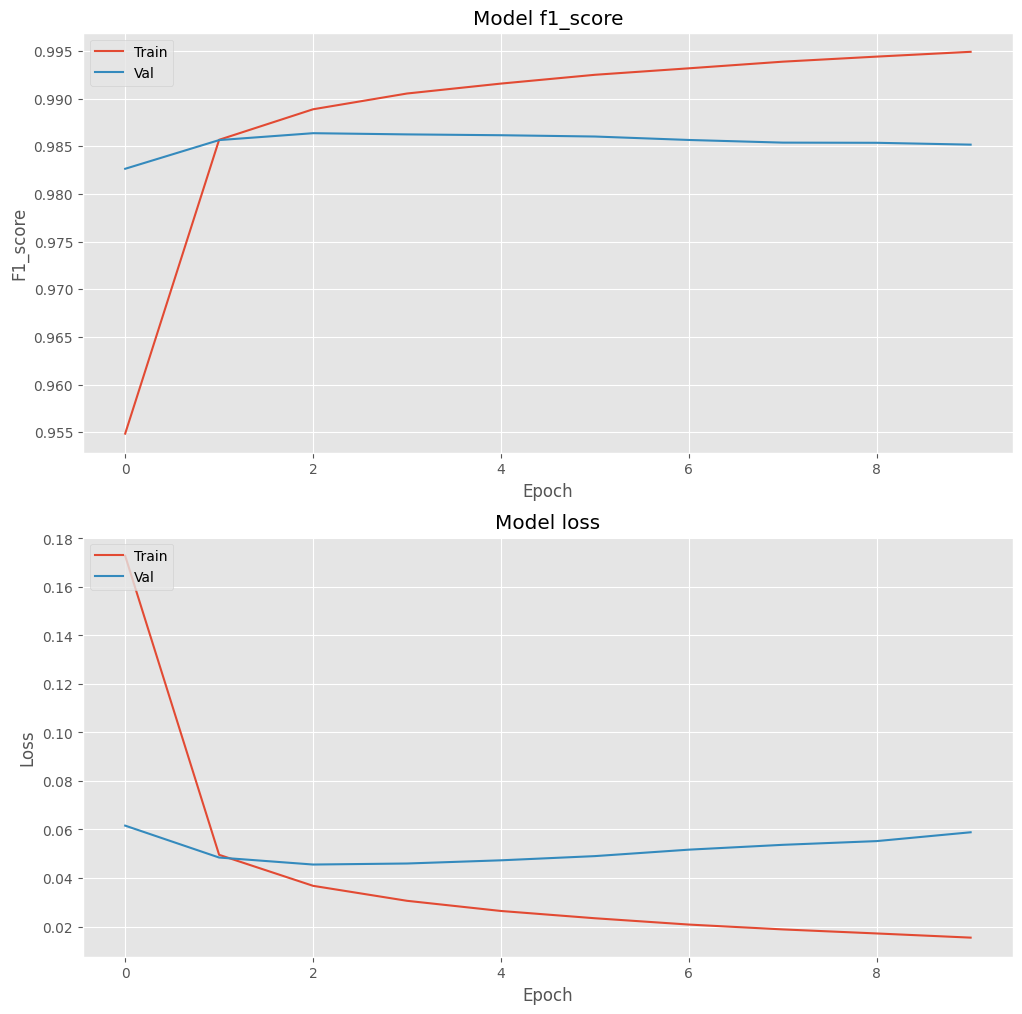

In [19]:
# Converta o dicionário history.history em um DataFrame do pandas
hist = pd.DataFrame(history.history)

# Crie uma figura com subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plotar training & validation accuracy
axs[0].plot(hist["f1_score"])
axs[0].plot(hist["val_f1_score"])
axs[0].set_title('Model f1_score')
axs[0].set_ylabel('F1_score')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Val'], loc='upper left')

# Plotar training & validation loss
axs[1].plot(hist["loss"])
axs[1].plot(hist["val_loss"])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Val'], loc='upper left')

# Mostrar o plot
plt.show()

In [20]:
%%time
scores = model.evaluate(X_te, np.array(y_te), verbose=2, batch_size=100)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

48/48 - 1s - loss: 0.0576 - f1_score: 0.9858 - 1s/epoch - 27ms/step
f1_score: 98.58%
CPU times: user 1.4 s, sys: 27.1 ms, total: 1.43 s
Wall time: 1.36 s


In [21]:
i = 2318
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))

1/1 [==============================] - 0s 413ms/step
Word            (True ): Pred
The            : O
head           : O
of             : O
South          : B-geo
Korea          : I-geo
's             : O
ruling         : O
Uri            : B-per
Party          : I-per
has            : O
resigned       : O
after          : O
parliament     : O
failed         : O
to             : O
pass           : O
several        : O
pieces         : O
of             : O
reform         : O
legislation    : O
by             : O
the            : O
end            : B-tim
of             : I-tim
2004           : I-tim
.              : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         